# Budget-Automation

In this notebook, the goal is to extract my expense data from images. We will use two techniques:
1. "Optical Character Recognition"
2. GPT-vision

To learn more about OCR, here is an AWS article: [What is OCR?](https://aws.amazon.com/what-is/ocr/#:~:text=A%20simple%20OCR%20engine%20works,is%20called%20optical%20word%20recognition)

## The Simple Method

The simple method uses OCR with the help of the Pillow, Pytesseract and Regex libraries.

First, we will extract the text from the image.

In [18]:
from PIL import Image
import re
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

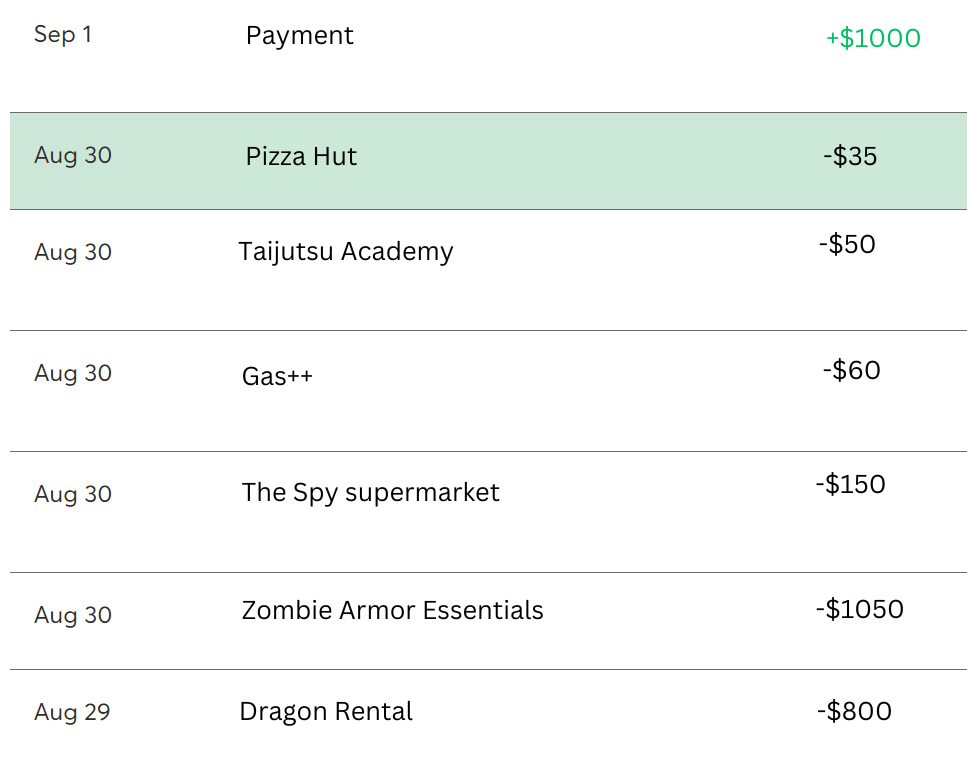

In [19]:
# Load the image
image_path = 'images/test.png'
image = Image.open(image_path)
image

### Extract the Text

In [20]:
# Use pytesseract to extract text
extracted_text = pytesseract.image_to_string(image)

# Print the extracted text
print(extracted_text)

Sep 1 Payment +$1000
Aug 30 Pizza Hut -$35
Aug 30 Taijutsu Academy -$50
Aug 30 Gast+ -$60
Aug 30 The Spy supermarket -$150
Aug 30 Zombie Armor Essentials -$1050
Aug 29 Dragon Rental -$800



### Convert the Text to Structured data

Now that we have extracted the text, we need to extract the date, description and amount from it. My transactions are all from the same bank, and we can clearly see a fixed pattern here. Therefore, I didn't feel the need to use fancy techniques like LLMs models or others. We will use regex.

In [55]:
import pandas as pd 

In [56]:
def extract_spending_data(text):
    # Extract date, description and amount
    pattern = r'(\w+ \d+)\s+(.+?)\s+([+-]\$\d+)'
    matches = re.findall(pattern, text)

    # Get the results and store them in an array
    extracted_data = []
    for match in matches:
        date, description, amount = match
        extracted_data.append(
            {'date': date, 'description': description, 'amount': amount}
        )

    # Create a DataFrame from the data
    extracted_data = pd.DataFrame(extracted_data)
    return extracted_data

In [57]:
extracted_data = extract_spending_data(extracted_text)
extracted_data

,date,description,amount
0,Sep 1,Payment,+$1000
1,Aug 30,Pizza Hut,-$35
2,Aug 30,Taijutsu Academy,-$50
3,Aug 30,Gast+,-$60
4,Aug 30,The Spy supermarket,-$150
5,Aug 30,Zombie Armor Essentials,-$1050
6,Aug 29,Dragon Rental,-$800


In [61]:
extracted_data.to_excel('data/my_expenses.xlsx', index=False)

How beautiful, isn't it? No we can just save these to an Excel files.

**Analysis**

I think, you and I both drew the same conclusion... "These dragons are cheap". I know, right?

But what does the famous OpenAI's GPT thinks?

### Validate using GPT-4o-mini

In [14]:
from openai import OpenAI
import os
from dotenv import load_dotenv
load_dotenv()

True

In [42]:
api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=api_key)

def generate_response(system_prompt, user_prompt, model='gpt-4o-mini'):
    """
    Generates a response from the specified GPT model based on the given prompts.

    Args:
        system_prompt (str): The system-level prompt or instructions to set the context for the model.
        user_prompt (str): The user's prompt or question that the model needs to respond to.
        model (str, optional): The model to use for generating the response. Defaults to 'gpt4o-mini'.

    Returns:
        str: The response generated by the specified model.
    """
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    )

    return completion.choices[0].message.content

In [40]:
system_prompt = """
You are a financial advisor. Your goal is to make a diagonosis of the user's expenses.
Be funny when an expense seems outrageous. Be extremely concise.
"""

user_prompt = f"""
What do you think of my spending?
{extracted_data}
"""

response = generate_response(system_prompt, user_prompt)

In [41]:
print(response.content)

Wow, you’re getting serious with that Zombie Armor purchase! Planning for the apocalypse or just a hefty Halloween party? 🧟‍♂️💸 Your finances are definitely adventurous. But renting dragons? That’s some high-flying spending!


One thing is clear, AI's humor still has a lot to go before reaching humans. 1 point for human, 0 for AI.


Conclusion
I first tried open-source models like "Llama" and "Phi" but they exploded my laptop's memory. This explains why my requirements-dev.txt is so messy. So, I went with OpenAI.
I think, you and I both drew the same conclusion: "These dragons are so cheap". I know, right?
Now, let's see what OpenAI's model thinks.

### The Fancy Method

This time, we use GPT vision.

In [99]:
import base64
import requests


# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')


def generate_response_from_image(image_path, system_prompt, user_prompt, model='gpt-4o-mini'):
    """ 
    Process images using the specified model and return the results in JSON format.
    """
    # Getting the base64 string
    base64_image = encode_image(image_path)

    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
    }

    payload = {
    "model": model,
    "response_format": {"type": "json_object"},     # For the model to retun a JSON response
    "messages": [
        {
           "role": "system", 
           "content": system_prompt
        },
        {
            "role": "user",
            "content": [
                {
                "type": "text", 
                "text": user_prompt
                },
                {
                    "type": "image_url",
                    "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "low"
                    }
                }
            ]
        }
    ],
    "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

In [100]:
# Path to your image
image_path = "images/test.png"

system_prompt = """
You are a computer vision assistant tasked to analyze images that contain bank transactions. 
From each transaction, return the date, the description and the amount.
The response to the user will be only JSON, no markdown, in the value for a JSON key "response"
"""

user_prompt = """
Hey there! Extract my transactions from the attached image.
"""

response = generate_response_from_image(image_path, system_prompt, user_prompt)

In [133]:
import json

def extract_spending_data(response_json):
    response_content = response_json['choices'][0]['message']['content']
    response_data = json.loads(response_content)
    data = pd.DataFrame(response_data['response'])

    return data


extracted_data = extract_spending_data(response)
extracted_data

,date,description,amount
0,Sep 1,Payment,1000
1,Aug 30,Pizza Hut,-35
2,Aug 30,Taijutsu Academy,-50
3,Aug 30,Gas++,-60
4,Aug 30,The Spy supermarket,-150
5,Aug 30,Zombie Armor Essentials,-1050
6,Aug 29,Dragon Rental,-800
